## Setup

In [1]:
!apt-get update && apt-get install swig cmake
!pip install box2d-py
!pip install "stable-baselines3[extra]>=2.0.0a4"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [43.3 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [456 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [979 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://securi

In [2]:
import torch
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
import gymnasium as gym
from gymnasium.spaces import *
import numpy as np
import copy

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


Configuration of the environment

In [3]:
max_floor = 5
max_capacity = 10
time_per_floor = 0.0167
time_per_person = 0.033
stationary_cost = 0.5

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Passenger Generation

In [4]:
class Passenger(object):
    def __init__(self, floor, destination, laichzeit, entry_time=0):
        self.floor = floor
        self.destination = destination
        self.laichzeit = laichzeit
        self.intent = self.floor > self.destination  # 1 for down 0 for up
        self.entry_time = entry_time
        # self.in_elevator = False

    def __str__(self) -> str:
        return f"this passgner is spawned at {self.laichzeit} at floor {self.floor} trying to reach {self.destination}"

### Generator

In [5]:
class Rider_Generator():
    def __init__(self, max_floor) -> None:
        self.waiting_list = {}
        self.total_passenger_count = 0

    def prepare(
        self,
        sigma=60,
        sigma2=90,
        morning_peak_time=480,
        lunch_volume=5 * max_capacity,
        morning_evening_volume=10 * max_capacity,
        lunch_peak_time_up=810,
        evening_peak_time=1020,
        lunch_peak_time_down=690
    ):
        X1 = np.random.normal(morning_peak_time, sigma, morning_evening_volume)
        X2 = np.random.normal(lunch_peak_time_up, sigma2, lunch_volume)
        X_up = np.concatenate([X1, X2])

        X3 = np.random.normal(lunch_peak_time_down, sigma2, lunch_volume)
        X4 = np.random.normal(evening_peak_time, sigma, morning_evening_volume)
        X_down = np.concatenate([X3, X4])
        return X_up, X_down

    def spawn(self, X_up, X_down):
        rng = np.random.default_rng()
        up_floors_calls = rng.exponential(scale=5, size=X_up.shape[0]) - 1
        up_floors_calls = np.round(up_floors_calls)  # + 1
        up_floors_calls = np.clip(up_floors_calls, a_min=0, a_max=max_floor - 2)
        up_floors_destinations = rng.uniform(
            up_floors_calls, max_floor - 1, X_up.shape[0]
        )
        up_floors_destinations = np.clip(
            np.round(up_floors_destinations), a_min=0, a_max=max_floor - 1
        )

        down_floors_calls = rng.exponential(scale=5, size=X_down.shape[0])
        down_floors_calls = max_floor - np.round(down_floors_calls)
        down_floors_calls = np.clip(down_floors_calls, a_min=1, a_max=max_floor - 1)
        down_floors_destinations = rng.uniform(0, down_floors_calls, X_up.shape[0])
        down_floors_destinations = np.clip(
            np.round(down_floors_destinations), a_min=0, a_max=max_floor - 1
        )

        up_floors_calls = up_floors_calls[np.argsort(X_up)]
        down_floors_calls = down_floors_calls[np.argsort(X_down)]
        spawn_locations = np.concatenate((up_floors_calls, down_floors_calls))
        up_floors_destinations = up_floors_destinations[np.argsort(X_up)]
        down_floors_destinations = down_floors_destinations[np.argsort(X_down)]
        destinations = np.concatenate(
            (up_floors_destinations, down_floors_destinations)
        )

        spawn_times = np.concatenate((np.sort(X_up), np.sort(X_down)))
        return spawn_times, spawn_locations, destinations

    def assign_passengers(
        self,
        sigma=60,
        sigma2=90,
        morning_peak_time=480,
        lunch_volume=5 * max_capacity,
        morning_evening_volume=10 * max_capacity,
        lunch_peak_time_up=810,
        evening_peak_time=1020,
        lunch_peak_time_down=690
    ):
        if self.total_passenger_count != 0:
            return self.total_passenger_count, copy.deepcopy(self.waiting_list)
        for j in range(max_floor):
            self.waiting_list[j] = []
        X_up, X_down = self.prepare(
            sigma,
            sigma2,
            morning_peak_time,
            lunch_volume,
            morning_evening_volume,
            lunch_peak_time_up,
            evening_peak_time,
            lunch_peak_time_down,
        )
        spawn_times, spawn_locations, destinations = self.spawn(X_up, X_down)

        for i in range(len(spawn_locations)):
            idx = int(spawn_locations[i])
            passenger = Passenger(spawn_locations[i], destinations[i], spawn_times[i])
            self.waiting_list[idx].append(passenger)
        self.total_passenger_count = spawn_times.shape[0]
        return self.total_passenger_count, copy.deepcopy(self.waiting_list)

### Sample Passenger Generation

In [6]:
def plotting_peaks(Ups, Downs):
  fig, axes = plt.subplots(nrows=1, ncols=2)

  # Plot on the first subplot (left)
  axes[0].hist(Downs, 30, density=False)
  axes[0].set_xlabel('#th minute')
  axes[0].set_ylabel('# of Passengers')
  axes[0].set_title('Down Calls')

  # Plot on the second subplot (right)
  axes[1].hist(Ups, 30, density=False)
  axes[1].set_xlabel('#th minute')
  axes[1].set_ylabel('# of Passengers')
  axes[1].set_title('Up Calls')

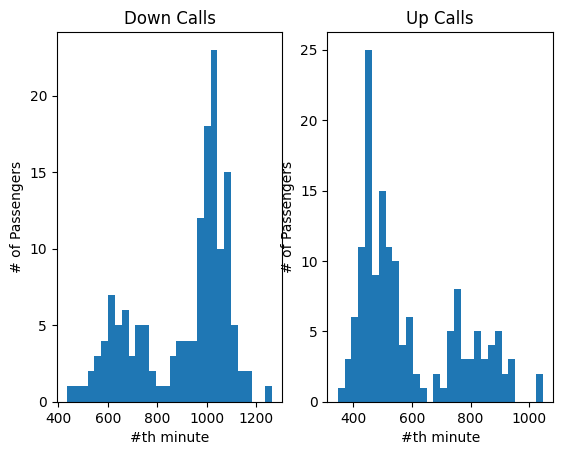

In [7]:
generator1 = Rider_Generator(max_floor)
going_up, going_down = generator1.prepare()
plotting_peaks(going_up, going_down)

## Environment

In [8]:
# Record the average waiting time of each episode
time_tracker = []

In [9]:
class Environemnt(gym.Env):
    metadata = {"render.modes": ["ansi"]}

    def __init__(self, render_mode="ansi"):
        """
        Action space is 0 for stop, 1 for moving up, and 2 for moving down.
        Observation space contains the total number of passengers wanting to go
        up or down respectively at each floor. Along with the current floor of
        the elevator car, the # of people wanting to go up and down.
        """
        super(Environemnt, self).__init__()
        self.total_waiting_time = 0
        self.curr_capacity = 0
        self.curr_floor = 0
        self.step_limit = 8192
        self.generator = Rider_Generator(max_floor)
        self.total_passenger_count, self.waiting_list = self.generator.assign_passengers()
        self.in_elevator_list = {}
        for j in range(max_floor):
            self.in_elevator_list[j] = []

        self.action_space = Discrete(3, start=0)
        self.observation_space = MultiDiscrete(
            ([self.total_passenger_count] * (-2 + max_floor * 2))
            + [max_capacity + 1, max_capacity + 1, max_floor]
        )

        # timer is set to the earliest spawn of the passenger
        self.timer = 450
        for floor in self.waiting_list:
          for p in self.waiting_list[floor]:
            if p.laichzeit < self.timer:
              self.timer = p.laichzeit

    def load_passengers(self):
        """
        Load passengers who is waiting (i.e., spawning_time < elevator_timer)
        each loaded passenger grants a reward of 50
        each loaded passenger waiting for more than a minute will be penalized by their waiting time.
        """
        reward = 0
        passengers_list = self.waiting_list[self.curr_floor]
        loaded = []
        waiting_times = 0
        for idx in range(len(passengers_list)):
            if self.curr_capacity >= max_capacity:
                break
            else:
                p = passengers_list[idx]
                waiting_time = self.timer - p.laichzeit
                if waiting_time > 0:
                    self.timer += time_per_person
                    self.curr_capacity += 1
                    p.entry_time = self.timer
                    self.in_elevator_list[p.destination].append(p)
                    loaded.append(idx)
                    reward += 50
                    waiting_times += waiting_time
                    if waiting_time > 1:
                      reward -= waiting_time

        loaded = sorted(loaded, reverse=True)
        for l in loaded:
            self.waiting_list[self.curr_floor].pop(l)
        return reward, waiting_times

    def offload_passengers(self):
        """
        each offloaded passenger grants a reward of 50
        """
        off_board = self.in_elevator_list[self.curr_floor]
        reward = len(off_board) * 50
        self.curr_capacity -= len(off_board)
        for i in off_board:
            self.timer += time_per_person
            # if self.timer - i.entry_time > stationary_cost * max_floor:
            #   reward -= int(self.timer - i.entry_time)
            # reward =
        self.in_elevator_list[self.curr_floor] = []
        return reward

    def step(self, action):
        """
        if the total waiting time is greater than the total passenger count,
        meaning that average waiting time is above 1 min,
        each additional episode will start with a reward of -50.
        Furthermore, each invalid move (i.e., moving down at floor 0 or up at max floor)
        results in -50 reward.
        """
        reward = 0
        if self.total_waiting_time > self.total_passenger_count:
          reward -= 50

        if action == 0:
            self.timer += stationary_cost
            offload_reward = self.offload_passengers()
            loading_reward, current_wait_times= self.load_passengers()
            reward += loading_reward + offload_reward
            self.total_waiting_time += current_wait_times

        if action == 1:
            if self.curr_floor == max_floor - 1:
                reward -= 50
                self.timer += stationary_cost
            else:
                self.timer += time_per_floor
                self.curr_floor += 1

        if action == 2:
            if self.curr_floor == 0:
                reward -= 50
                self.timer += stationary_cost
            else:
                self.timer += time_per_floor
                self.curr_floor -= 1

        truncated = False
        self.step_limit -= 1
        info, terminated, observation = self.get_state()
        if self.step_limit == 0:
            truncated = True
            terminated = True
        if terminated:
          time_tracker.append(info["Average_waiting_time"])
        return observation, float(reward), terminated, truncated, info


    def get_state(self):
        passenger_count = 0
        global_state = np.zeros(len(self.waiting_list.keys()) * 2 + 1, dtype=int)
        for i in self.waiting_list.keys():
            for passenger in self.waiting_list[i]:
                if passenger.laichzeit <= self.timer:
                    global_state[2 * i - passenger.intent] += 1
            passenger_count += len(self.waiting_list[i])
        ups, downs = 0, 0
        for j in self.in_elevator_list.keys():
            for p in self.in_elevator_list[j]:
                if p.destination < self.curr_floor:
                    downs += 1
                else:
                    ups += 1

        global_state[-3] = ups
        global_state[-2] = downs
        global_state[-1] = self.curr_floor

        info = {"Average_waiting_time": self.total_waiting_time / max(1, self.total_passenger_count - passenger_count)}
        is_done = (passenger_count == 0 and self.curr_capacity == 0)

        if passenger_count != 0:
          next_time_jump = float("inf")
          for f in self.waiting_list:
            for p in self.waiting_list[f]:
              if p.laichzeit < next_time_jump:
                next_time_jump = p.laichzeit
          if next_time_jump > self.timer:
            self.timer = next_time_jump

        return info, is_done, global_state

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.curr_capacity = 0
        self.curr_floor = 0
        self.total_waiting_time = 0

        for j in self.in_elevator_list.keys():
            self.in_elevator_list[j] = []
        self.total_passenger_count, self.waiting_list= self.generator.assign_passengers()
        self.timer = 450
        for floor in self.waiting_list:
          for p in self.waiting_list[floor]:
            if p.laichzeit < self.timer:
              self.timer = p.laichzeit
        self.step_limit = 8192
        info, _, obs = self.get_state()
        return obs, info

    def render(self, mode="ansi", close=False):
        """
        Inspired from
        https://github.com/saykim/elevator-reinforcementlearning-application/blob/master/environment/Building.py
        """

        for floor in range(max_floor - 1, -1, -1):
            print("=========================")
            print(f"=     Floor {floor}    =", end=' ')
            if self.curr_floor == floor:
              print("  Lift  ", end=' ')
            else:
              print("         ", end=' ')
            print(" ")
            if self.curr_floor == floor:
              print(f"    in elevator: {self.curr_capacity}   ", end=' ')
            else:
              print("          ", end=' ')
            print(" ")
            print(f"=    remaining: {len(self.waiting_list[floor])}    =")
        print("=========================")
        print("\n\n\n")
        # print("People to move: %d "%(self.remain_passengers_num - len(self.floors_information[0])))
        # print("Total # of people: %d"%self.total)

### Environemnt Check

In [10]:
log_dir = "/content/elevator/"
os.makedirs(log_dir, exist_ok=True)

building = Environemnt()
env_checker.check_env(building, True, True)
building = Monitor(building, log_dir)

## Training

### Call back for saving the best model in terms of reward

In [11]:
"""
Copied from: https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/monitor_training.ipynb#scrollTo=pUWGZp3i9wyf
"""
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

### Start Training

In [12]:
from stable_baselines3.common.logger import configure

building.reset()
time_tracker = []
policy_kwargs = dict(
    activation_fn=torch.nn.ReLU,
    net_arch=dict(pi=[64, 32], vf=[64, 32]),
    share_features_extractor=False,
)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir, verbose=0)
logger = configure(log_dir, ["json", "csv"])

model = PPO(
    "MlpPolicy",
    building,
    clip_range=0.2,
    clip_range_vf=0.05,
    gae_lambda=0.7,
    policy_kwargs=policy_kwargs,
    verbose=1
)
model.set_logger(logger)
model.learn(total_timesteps=40960, callback=callback)

Using cpu device
Wrapping the env in a DummyVecEnv.


## Visualization

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


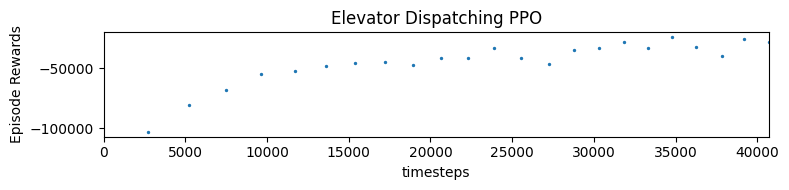

In [13]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "Elevator Dispatching PPO"
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Average waiting time per episode')

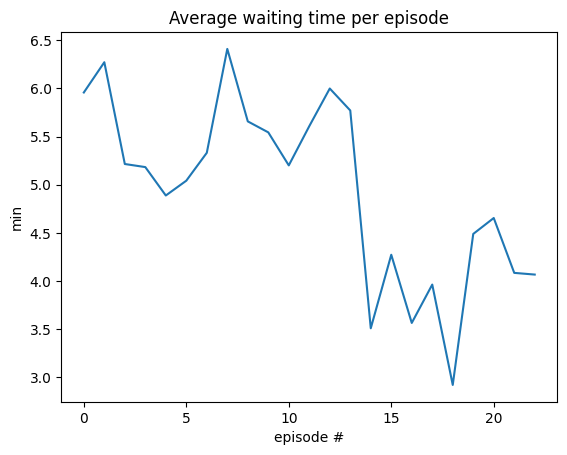

In [14]:
plt.plot(range(len(time_tracker)),time_tracker)
plt.xlabel('episode #')
plt.ylabel('min')

# displaying the title
plt.title("Average waiting time per episode")

Rendering Demo

In [15]:
import time
obs, _ = building.reset()
done, state = False, None
episode_reward = 0.0
episode_length = 0
while not done:
  action, state = model.predict(obs, state=state, deterministic=True)
  obs, reward, done, truncated, info = building.step(action)
  episode_reward += reward
  episode_length += 1
  building.render()
  time.sleep(0.1)

Streaming output truncated to the last 5000 lines.
=     Floor 4    =            
            
=    remaining: 37    =
=     Floor 3    =   Lift    
    in elevator: 10     
=    remaining: 49    =
=     Floor 2    =            
            
=    remaining: 23    =
=     Floor 1    =            
            
=    remaining: 85    =
=     Floor 0    =            
            
=    remaining: 43    =




=     Floor 4    =            
            
=    remaining: 37    =
=     Floor 3    =   Lift    
    in elevator: 10     
=    remaining: 49    =
=     Floor 2    =            
            
=    remaining: 23    =
=     Floor 1    =            
            
=    remaining: 85    =
=     Floor 0    =            
            
=    remaining: 43    =




=     Floor 4    =            
            
=    remaining: 37    =
=     Floor 3    =   Lift    
    in elevator: 10     
=    remaining: 49    =
=     Floor 2    =            
            
=    remaining: 23    =
=     Floor 1    =      

KeyboardInterrupt: ignored